In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Load CIFAR-10 dataset
transforms_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)

cuda


100%|██████████| 170498071/170498071 [00:04<00:00, 36252377.42it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# Custom MLP

In [2]:
class Perceptron(nn.Module):
  def __init__(self, num_inputs):
    super(Perceptron, self).__init__()
    self.weights = nn.Parameter(nn.init.xavier_uniform_(torch.Tensor(1, num_inputs)))
    self.bias = nn.Parameter((torch.randn(1)))

  def propagate(self, inputs):
    output = torch.dot(inputs, self.weights.view(-1)) + self.bias
    return output

class MultiLayerPerceptron(nn.Module):
  def __init__(self):
    super(MultiLayerPerceptron, self).__init__()
    self.hidden_layer1 = nn.ModuleList([Perceptron(32 * 32 * 3) for i in range(128)])
    self.hidden_layer2 = nn.ModuleList([Perceptron(128) for i in range(64)])
    self.output_layer = nn.ModuleList([Perceptron(64) for i in range(10)])

  def propagate(self, inputs):
        # Flatten the input data
        inputs = inputs.view(-1, 32 * 32 * 3)

        # Store the matrices of weights
        hidden1_weights = torch.stack([perceptron.weights for perceptron in self.hidden_layer1])
        hidden1_weights = hidden1_weights.squeeze(dim=1)
        hidden2_weights = torch.stack([perceptron.weights for perceptron in self.hidden_layer2])
        hidden2_weights = hidden2_weights.squeeze(dim=1)
        output_weights = torch.stack([perceptron.weights for perceptron in self.output_layer])
        output_weights = output_weights.squeeze(dim=1)

        # Store the vectors of biases
        hidden1_bias = torch.stack([perceptron.bias for perceptron in self.hidden_layer1])
        hidden1_bias = hidden1_bias.view(-1)
        hidden2_bias = torch.stack([perceptron.bias for perceptron in self.hidden_layer2])
        hidden2_bias = hidden2_bias.view(-1)
        output_bias = torch.stack([perceptron.bias for perceptron in self.output_layer])
        output_bias = output_bias.view(-1)

        # Creating output list
        outputs_list = []

        for picture, pixels in enumerate(inputs):
          pixels = torch.relu(F.linear(pixels, hidden1_weights, hidden1_bias))
          pixels = torch.relu(F.linear(pixels, hidden2_weights, hidden2_bias))
          outputs_list.append(F.linear(pixels, output_weights, output_bias))

        # Concatenate the output tensors along the 0th dimension
        output = torch.stack(outputs_list)
        return output.squeeze()

In [7]:
# Model Testing
model = MultiLayerPerceptron()
weights_path = '/content/drive/My Drive/Colab Notebooks/CSE498R/CIFAR10_a_498R_custom_model_weights.pth'
model.load_state_dict(torch.load(weights_path))
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for batch in test_loader:
    images, labels = batch
    outputs = model.propagate(images)
    _,predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy1 = (correct / total)*100
print(accuracy1, "%")

49.9 %


# Prebuilt MLP

In [8]:
# Define a simple feedforward neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 128)  # Input: 28x28 image, Output: 128
        self.fc2 = nn.Linear(128, 64)      # Hidden layer: 128 -> 64
        self.fc3 = nn.Linear(64, 10)      # Output: 32 -> 10 (10 classes for MNIST)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [12]:
# Model Testing
model2 = NeuralNetwork()
weights_path = '/content/drive/My Drive/Colab Notebooks/CSE498R/CIFAR10_a_498R_prebuilt_model_weights.pth'
model2.load_state_dict(torch.load(weights_path))
model2.eval()
correct = 0
total = 0
with torch.no_grad():
  for batch in test_loader:
    images, labels = batch
    outputs = model2(images)
    _,predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
accuracy2 = (correct / total)*100
print(accuracy2, "%")

50.580000000000005 %


# Inter Layer Analysis

## Extracting the weights layer-wise

In [13]:
hidden_layer1_weights = []
hidden_layer2_weights = []
output_layer_weights = []

for name, weight in model.named_parameters():
  if "weights" in name:
    if "hidden_layer1" in name:
      hidden_layer1_weights.append(weight[0].detach().numpy())
    elif "hidden_layer2" in name:
      hidden_layer2_weights.append(weight[0].detach().numpy())
    else:
      output_layer_weights.append(weight[0].detach().numpy())

In [14]:
print((output_layer_weights[0]))

[ 0.22331768  0.1530987   0.07086481  0.26655817 -0.21977773 -0.13640328
 -0.23508409  0.02556066  0.3351948  -0.14867452 -0.08482471  0.11609118
 -0.02340962 -0.00143599 -0.27262193 -0.29071242 -0.15695713  0.12854236
 -0.10872287  0.15083458 -0.16286874 -0.26805106 -0.31825465  0.24129641
 -0.1130091   0.03776505 -0.26745683 -0.20073445 -0.11910754  0.06787212
  0.16876096 -0.22147025  0.05977404 -0.06361249  0.02357869  0.17681219
 -0.1259712  -0.18100403  0.10436481  0.00747519  0.11474399  0.13568546
 -0.24230848  0.12134311 -0.28440377 -0.11272954  0.2146718   0.26526612
 -0.0710872  -0.20381312  0.192041   -0.03473902  0.3399875  -0.2293223
  0.16171493 -0.11643559  0.22428773 -0.0419663  -0.1514047   0.00764936
 -0.25464055 -0.17938964 -0.19111611 -0.21130387]


## Weights from Hidden Layer 1 to Hidden Layer 2

In [15]:
outgoing_weights1 = []
for neuron in range(128):
  weights = []
  for i in range(64):
    weights.append(hidden_layer2_weights[i][neuron])
  outgoing_weights1.append(weights)
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(range(0, 64), weights, marker='o', linestyle='-', color='blue')

  # Set titles and labels
  ax.set_title(f'Weight Distribution in Hidden Layer 2 of Neuron {neuron} from Hidden Layer 1')
  ax.set_xlabel('Neuron')
  ax.set_ylabel('Weight')

  # Add a legend
  ax.legend()

  # Show the plot
  plt.tight_layout()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Weights from Hidden Layer 2 to Output Layer

In [16]:
outgoing_weights = []
for neuron in range(64):
  weights = []
  for i in range(10):
    weights.append(hidden_layer2_weights[i][neuron])
  outgoing_weights.append(weights)
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.plot(range(0, 10), weights, marker='o', linestyle='-', color='green')

  # Set titles and labels
  ax.set_title(f'Weight Distribution in Output Layer of Neuron {neuron} from Hidden Layer 2')
  ax.set_xlabel('Neuron')
  ax.set_ylabel('Weight')

  # Add a legend
  ax.legend()

  # Show the plot
  plt.tight_layout()
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

## KL-Divergence of Incoming and Outgoing Weights - Hidden Layer 1

In [19]:
print(len(outgoing_weights1[0]))
print(len(hidden_layer1_weights[0]))

64
3072


In [20]:
from scipy.special import kl_div
kl_divs1 = []

for i in range(128):
  padded_distribution = np.pad(outgoing_weights1[i], (0, 3008))
  kl_divergences = kl_div(padded_distribution, hidden_layer1_weights[i])
  kl_divergence = [kl.item() for kl in kl_divergences if kl != float('inf')]
  kl_divergence = sum(kl_divergence)
  kl_divs1.append(kl_divergence)

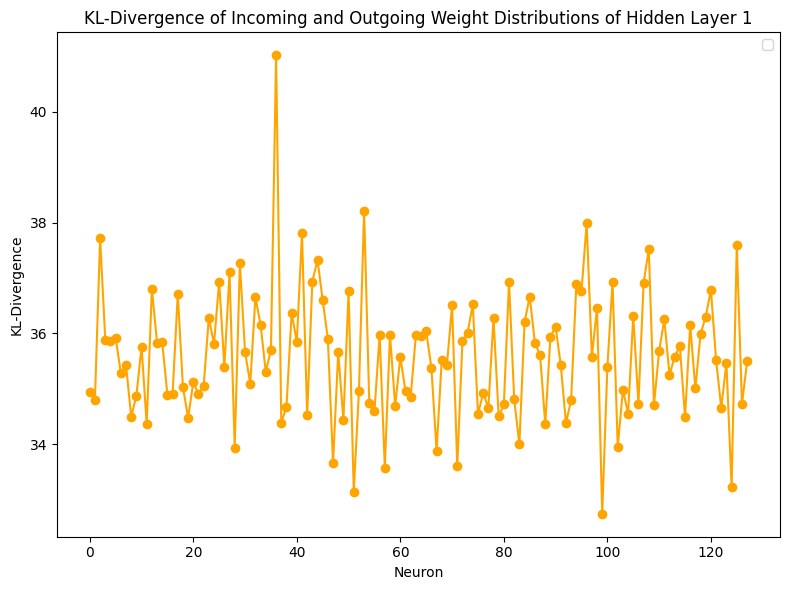

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(0, 128), kl_divs1, marker='o', linestyle='-', color='orange')

# Set titles and labels
ax.set_title(f'KL-Divergence of Incoming and Outgoing Weight Distributions of Hidden Layer 1')
ax.set_xlabel('Neuron')
ax.set_ylabel('KL-Divergence')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

## KL-Divergence of Incoming and Outgoing Weights - Hidden Layer 2

In [22]:
print(len(outgoing_weights))
print(len(hidden_layer2_weights))

64
64


In [23]:
from scipy.special import kl_div
kl_divs = []

for i in range(64):
  padded_distribution = np.pad(outgoing_weights[i], (0, 118))
  kl_divergences = kl_div(padded_distribution, hidden_layer2_weights[i])
  kl_divergence = [kl.item() for kl in kl_divergences if kl != float('inf')]
  kl_divergence = sum(kl_divergence)
  kl_divs.append(kl_divergence)

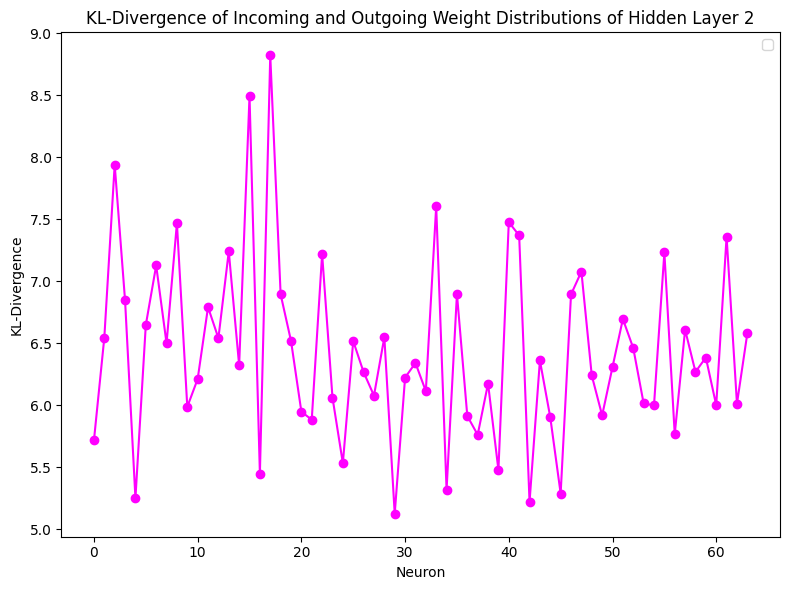

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(0, 64), kl_divs, marker='o', linestyle='-', color='magenta')

# Set titles and labels
ax.set_title(f'KL-Divergence of Incoming and Outgoing Weight Distributions of Hidden Layer 2')
ax.set_xlabel('Neuron')
ax.set_ylabel('KL-Divergence')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# prebuilt_hidden_layer1_weights = []
# prebuilt_hidden_layer2_weights = []
# prebuilt_output_layer_weights = []

# for name, weight in model2.named_parameters():
#   if "weights" in name:
#     if "hidden_layer1" in name:
#       hidden_layer1_weights.append(weight[0].detach().numpy())
#     elif "hidden_layer2" in name:
#       hidden_layer2_weights.append(weight[0].detach().numpy())
#     else:
#       output_layer_weights.append(weight[0].detach().numpy())